# 03 - Predicting Medical Expenses

The goal of this mini project is to build a regression model that predicts the annual medical expenses that a person is expected to give to a healthcare company. This prediction is based on health profiles estimated from personal characteristics such as age, body mass index, smoking habits, number of children, among others.

For this task we'll use a data set containing historical information about 1338 healthcare clients from the North, Northeast, Southeast and South regions of Brazil.

In [1]:
suppressWarnings(library(ggplot2))
suppressWarnings(library(GGally))
suppressWarnings(library(corrplot))
suppressWarnings(library(caret))

Loading required package: lattice


## 1 Data load

In [2]:
# Data is in CSV format.
df <- read.csv('expenses.csv')

In [3]:
# Get some data info.
str(df)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ gender  : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 25.7 33.4 27.7 29.8 25.8 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "north","northeast",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ expenses: num  16885 1726 4449 21984 3867 ...


In [4]:
head(df)

age,gender,bmi,children,smoker,region,expenses
19,female,27.9,0,yes,southeast,16884.92
18,male,33.8,1,no,south,1725.55
28,male,33.0,3,no,south,4449.46
33,male,22.7,0,no,northeast,21984.47
32,male,28.9,0,no,northeast,3866.86
31,female,25.7,0,no,south,3756.62


The data set contains (in principle) 6 predictors, where `age` and `bmi` are numerical and the others (`gender`, `children`, `smoker` and `region`) are categorical. The target variable (`expenses`) is numerical too, because this is a regression problem.

In [5]:
# Cut age values in groups.
df$agegroup <- cut(df$age, c(0, 30, 40, 50, 60, Inf))

In [6]:
# Cut BMI values in groups.
df$bmigroup <- cut(df$bmi, c(0, 18.5, 25, 30, Inf),
                   labels = c('underweight', 'normal', 'overweight', 'obese'))

In [7]:
str(df)

'data.frame':	1338 obs. of  9 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ gender  : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 25.7 33.4 27.7 29.8 25.8 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "north","northeast",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ expenses: num  16885 1726 4449 21984 3867 ...
 $ agegroup: Factor w/ 5 levels "(0,30]","(30,40]",..: 1 1 1 2 2 2 3 2 2 4 ...
 $ bmigroup: Factor w/ 4 levels "underweight",..: 3 4 4 2 3 3 4 3 3 3 ...


Rather than dealing with raw `age` and `bmi` values, perhaps it is more interesting to look at people in terms of age groups and BMI classifications (underweight, obese, etc). So 2 new features were generated to represent that.

In [8]:
# Count missing values.
sapply(df, function (x) {
    sum(is.na(x))
})

age   gender      bmi children   smoker   region expenses agegroup 
       0        0        0        0        0        0        0        0 
bmigroup 
       0

Fortunately, there are no missing values in this data set, so no worries with data imputation.

In [9]:
# Split the data set.
train.idx <- createDataPartition(df$expenses, p = 0.75, list = FALSE)
df.train <- df[train.idx, ]
df.test <- df[-train.idx, ]

In [10]:
# Training set size.
dim(df.train)

[1] 1006    9

In [11]:
# Test set size.
dim(df.test)

[1] 332   9

The original data was split into two independent sets, one for the model training and tuning (75% of the complete data set), and the other for tests and evaluation (25%).

## 2 Exploratory data analysis

In [12]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
#
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                         ncol = cols, nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}

### 2.1 Feature distributions

In [13]:
summary(df.train)

      age           gender         bmi           children     smoker   
 Min.   :18.00   female:496   Min.   :16.80   Min.   :0.000   no :800  
 1st Qu.:27.00   male  :510   1st Qu.:26.20   1st Qu.:0.000   yes:206  
 Median :39.00                Median :30.35   Median :1.000            
 Mean   :39.14                Mean   :30.55   Mean   :1.105            
 3rd Qu.:52.00                3rd Qu.:34.40   3rd Qu.:2.000            
 Max.   :64.00                Max.   :52.60   Max.   :5.000            
       region       expenses         agegroup          bmigroup  
 north    :250   Min.   : 1122   (0,30]  :340   underweight: 19  
 northeast:244   1st Qu.: 4740   (30,40] :197   normal     :171  
 south    :270   Median : 9382   (40,50] :192   overweight :292  
 southeast:242   Mean   :13258   (50,60] :207   obese      :524  
                 3rd Qu.:16640   (60,Inf]: 70                    
                 Max.   :63770                                   

In [14]:
# Set the default figure size.
options(repr.plot.width = 7, repr.plot.height = 2.5)

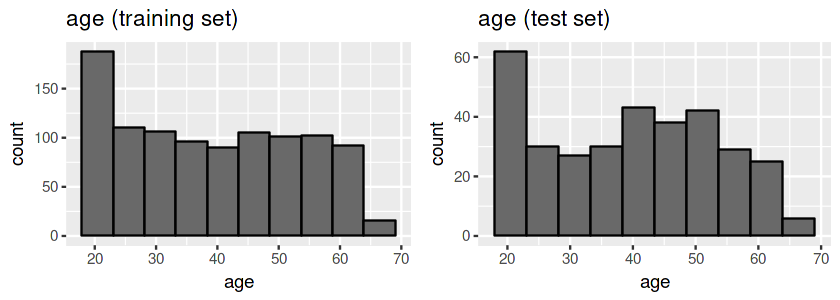

In [15]:
multiplot(ggplot(df.train, aes(x = age)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('age (training set)'),
          ggplot(df.test, aes(x = age)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('age (test set)'),
          cols = 2)

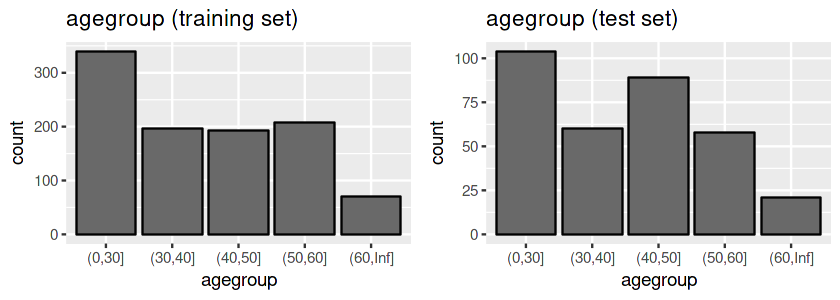

In [16]:
multiplot(ggplot(df.train, aes(x = agegroup)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('agegroup (training set)'),
          ggplot(df.test, aes(x = agegroup)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('agegroup (test set)'),
          cols = 2)

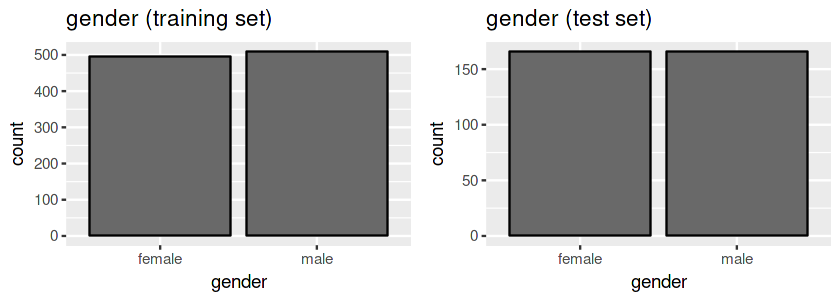

In [17]:
multiplot(ggplot(df.train, aes(x = gender)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('gender (training set)'),
          ggplot(df.test, aes(x = gender)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('gender (test set)'),
          cols = 2)

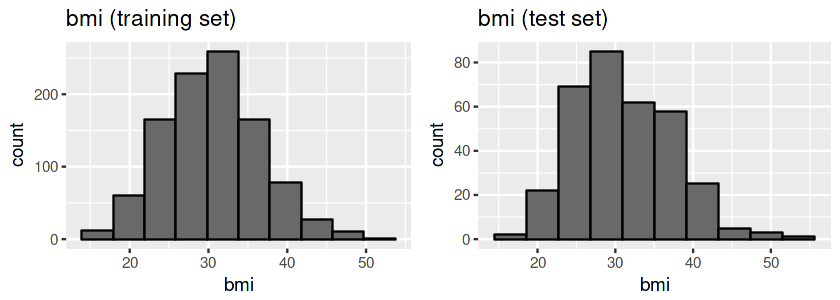

In [18]:
multiplot(ggplot(df.train, aes(x = bmi)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('bmi (training set)'),
          ggplot(df.test, aes(x = bmi)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('bmi (test set)'),
          cols = 2)

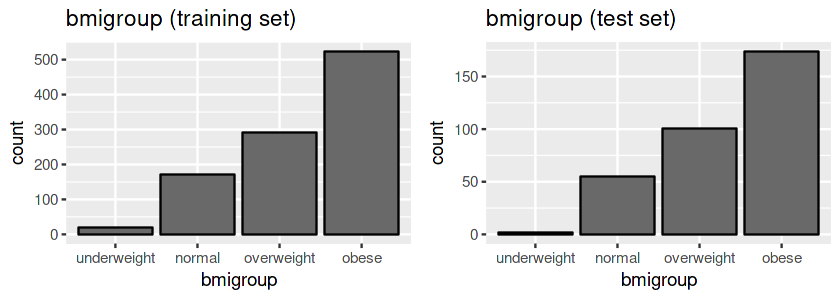

In [19]:
multiplot(ggplot(df.train, aes(x = bmigroup)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('bmigroup (training set)'),
          ggplot(df.test, aes(x = bmigroup)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('bmigroup (test set)'),
          cols = 2)

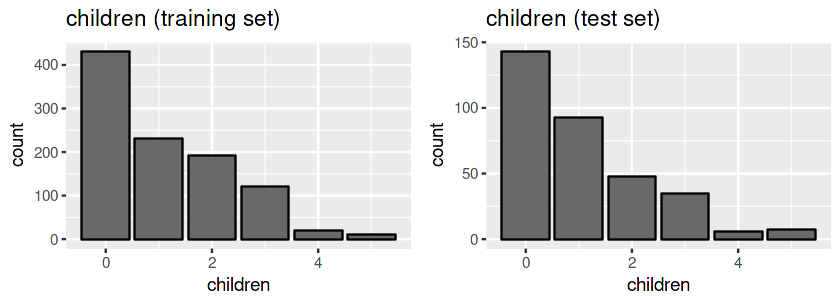

In [20]:
multiplot(ggplot(df.train, aes(x = children)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('children (training set)'),
          ggplot(df.test, aes(x = children)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('children (test set)'),
          cols = 2)

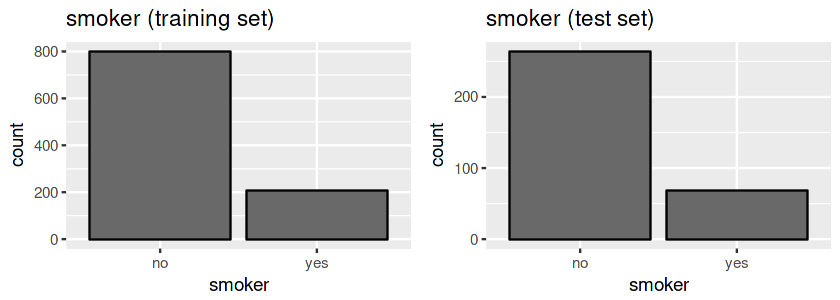

In [21]:
multiplot(ggplot(df.train, aes(x = smoker)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('smoker (training set)'),
          ggplot(df.test, aes(x = smoker)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('smoker (test set)'),
          cols = 2)

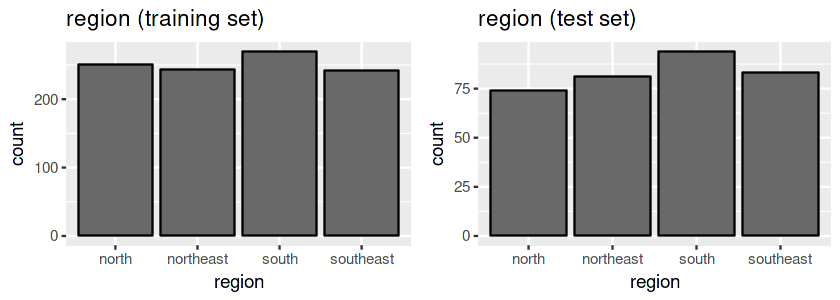

In [22]:
multiplot(ggplot(df.train, aes(x = region)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('region (training set)'),
          ggplot(df.test, aes(x = region)) +
              geom_bar(colour = 'black', fill = 'dimgrey') +
              ggtitle('region (test set)'),
          cols = 2)

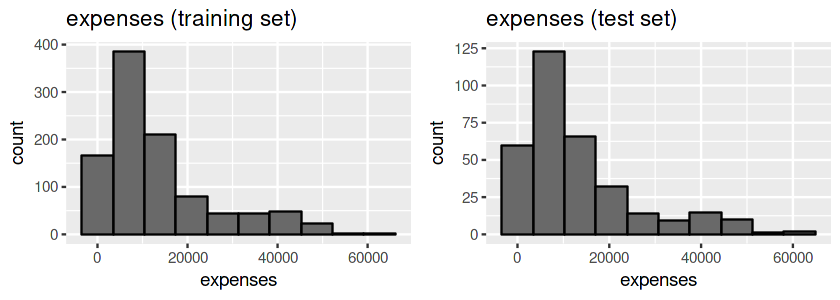

In [23]:
multiplot(ggplot(df.train, aes(x = expenses)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('expenses (training set)'),
          ggplot(df.test, aes(x = expenses)) +
              geom_histogram(bins = 10, colour = 'black', fill = 'dimgrey') +
              ggtitle('expenses (test set)'),
          cols = 2)

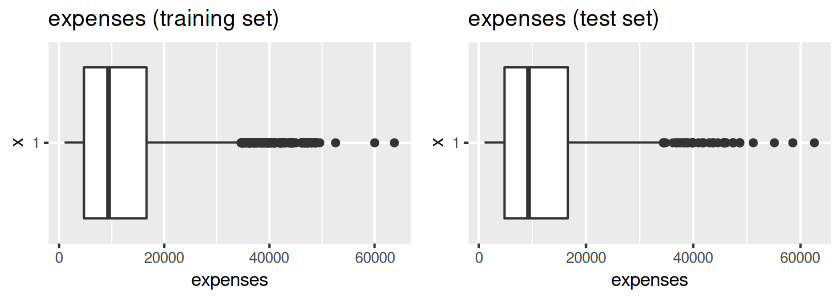

In [24]:
multiplot(ggplot(df.train, aes(x = '1', y = expenses)) +
              geom_boxplot() +
              coord_flip() +
              ggtitle('expenses (training set)'),
          ggplot(df.test, aes(x = '1', y = expenses)) +
              geom_boxplot() +
              coord_flip() +
              ggtitle('expenses (test set)'),
          cols = 2)

The exploratory data analysis began with a visualization of each feature's distribution. From the graphs above, the following facts can be observed:

- We have far more young people (under 30) than old people (over 60) in the data set.
- Men and women are present in equal proportions.
- BMIs look normally distributed, but the mean is around 30, which means that most people in the data set are overweight or obese!
- Most people in the data set have no children, and those with more than 3 children are really rare.
- About 1/4 of the people in the data set are smokers.
- People are equally distributed across the four regions.

### 2.2 Expenses vs. other features

In [25]:
# Set the default figure size.
options(repr.plot.width = 6, repr.plot.height = 3)

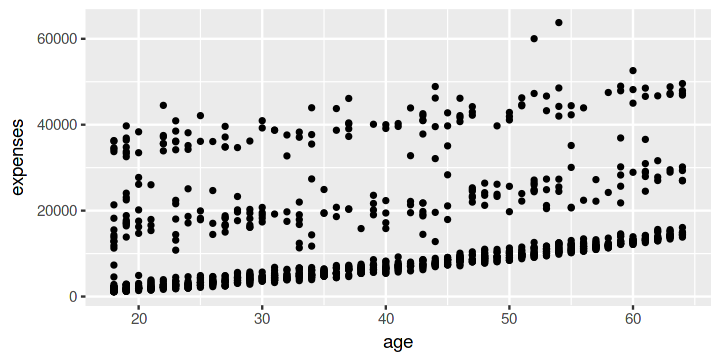

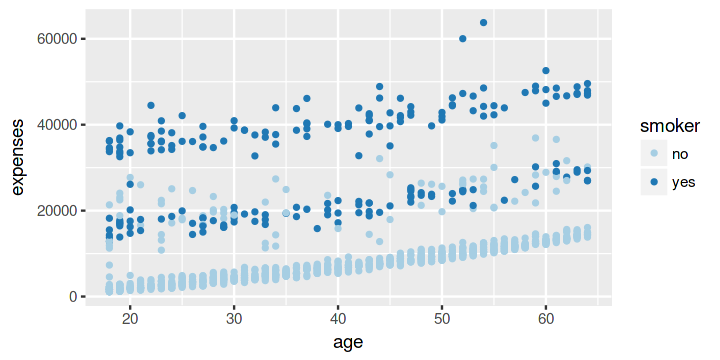

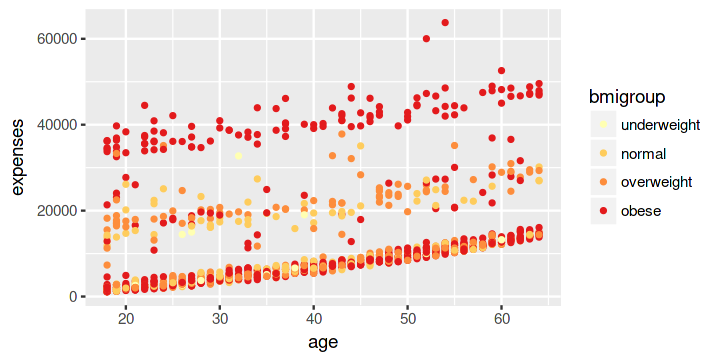

In [26]:
ggplot(df.train, aes(x = age, y = expenses)) +
    geom_point(size = 1)

ggplot(df.train, aes(x = age, y = expenses, colour = smoker)) +
    geom_point(size = 1) +
    scale_color_brewer(palette = 'Paired')

ggplot(df.train, aes(x = age, y = expenses, colour = bmigroup)) +
    geom_point(size = 1) +
    scale_color_brewer(palette = 'YlOrRd')

What we can observe now:

- There is an obvious upward trend between `age` and `expenses`: the older you get, the higher your medical expenses tend to become. However, this trend doesn't seem to be very significant considering the age alone.
- When we put the smokers in evidence, things get a lot clearer: being a smoker influences HUGELY in the medical expenses of people of all ages.
- Being obese can have a high impact in the expenses too. But, apparently, not so high as being a smoker, since there are obese people of all ages with little expenses.

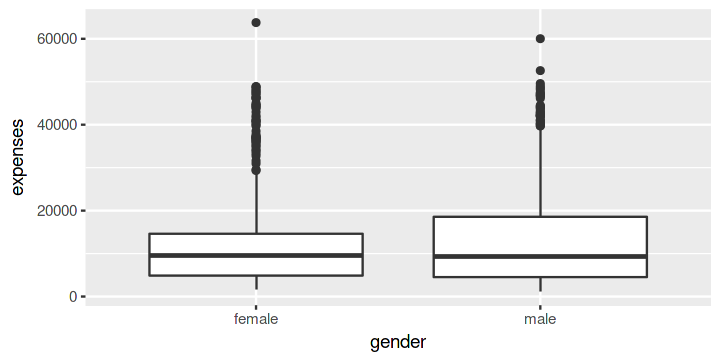

In [27]:
ggplot(df.train, aes(x = gender, y = expenses)) +
    geom_boxplot()

It looks like being a man or a woman doesn't make much difference in the medical expenses. There are more men with high expenses than women, however the averages are practically the same for both genders.

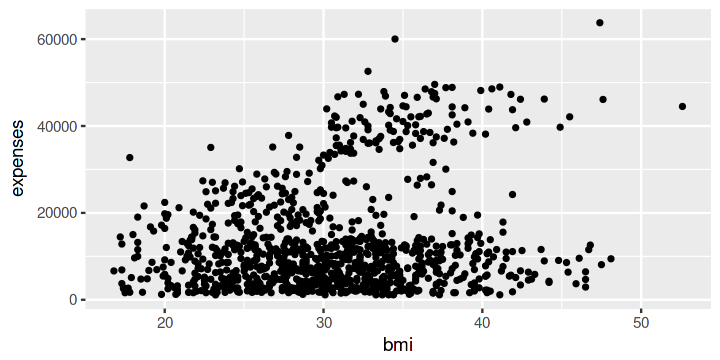

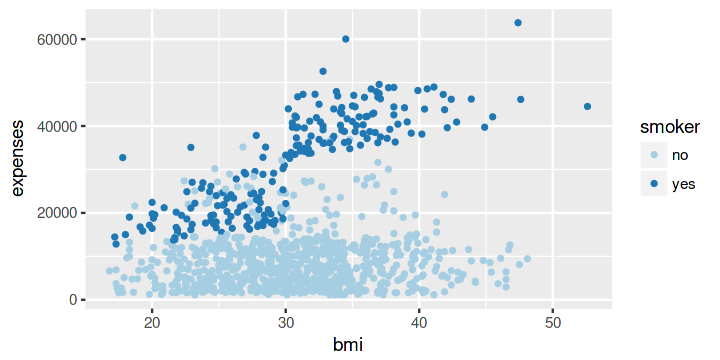

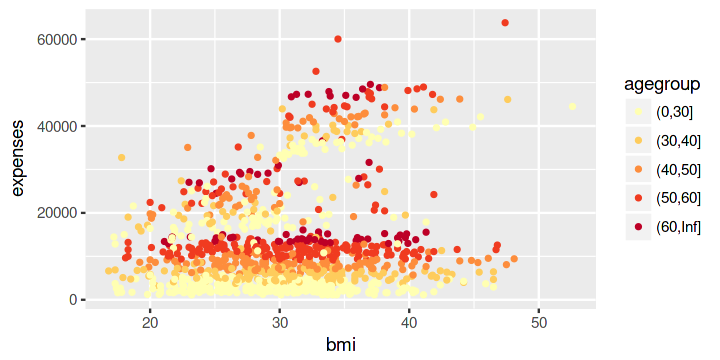

In [28]:
ggplot(df.train, aes(x = bmi, y = expenses)) +
    geom_point(size = 1)

ggplot(df.train, aes(x = bmi, y = expenses, colour = smoker)) +
    geom_point(size = 1) +
    scale_color_brewer(palette = 'Paired')

ggplot(df.train, aes(x = bmi, y = expenses, colour = agegroup)) +
    geom_point(size = 1) +
    scale_color_brewer(palette = 'YlOrRd')

As we already knew, a high BMI can impact the medical expenses. But this trend doesn't seem to be so significant considering the BMI alone. Putting smokers in evidence once more showed that being a smoker is the real killer. Even young and skinny people may expect to represent a higher cost for healthcare companies if they are smokers, in comparison to obese non-smokers.

In addition, the age groups were put in evidence too, to show the same `age`-`expense` relationship by another perspective.

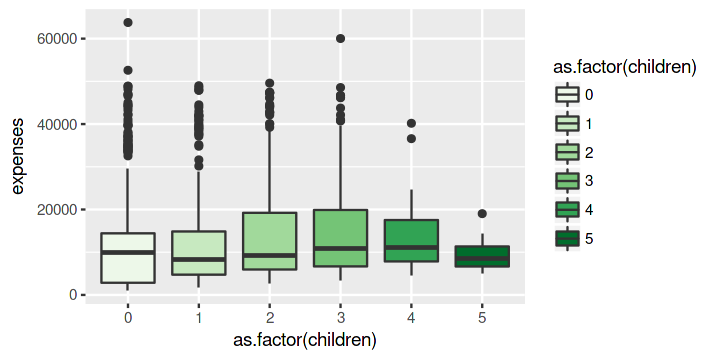

In [29]:
ggplot(df.train, aes(x = as.factor(children), y = expenses, fill = as.factor(children))) +
    geom_boxplot() +
    scale_fill_brewer(palette = 'Greens')

In [30]:
sum(df.train$children > 3) / nrow(df.train)

[1] 0.02982107

Contrary to some expectations, people with more children (above 3) aren't associated to higher medical expenses. In fact, their expenses are actually lower than the others in this data set. But we can't jump into conclusions: people with more than 3 children are less than 3% of our data set, so we just don't have enough data about them to state anything.

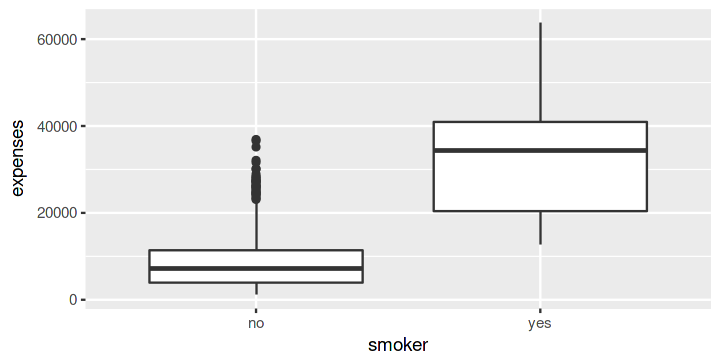

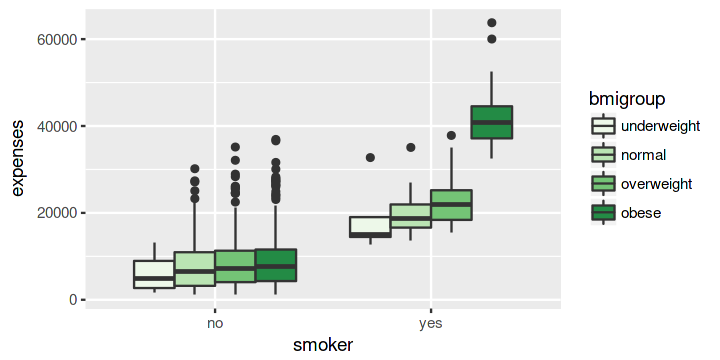

In [31]:
ggplot(df.train, aes(x = smoker, y = expenses)) +
    geom_boxplot()

ggplot(df.train, aes(x = smoker, y = expenses, fill = bmigroup)) +
    geom_boxplot() +
    scale_fill_brewer(palette = 'Greens')

In [32]:
max(df.train$expenses)

[1] 63770.43

In [33]:
min(df.train[df.train$smoker == 'yes' & df.train$bmigroup == 'obese', 'expenses'])

[1] 32548.34

Above we can see how distant obese smokers are from the other groups of people in terms of medical expenses. Being a smoker alone is bad, being obese too, but being both at the same time surely takes things to a new level. The minimum expense for an obese smoker is above \$32000, a mark reached only by a few outliers in the other groups. And the maximum expense among people from other groups is below \$40000, while for obese smokers this value goes beyond \$60000.

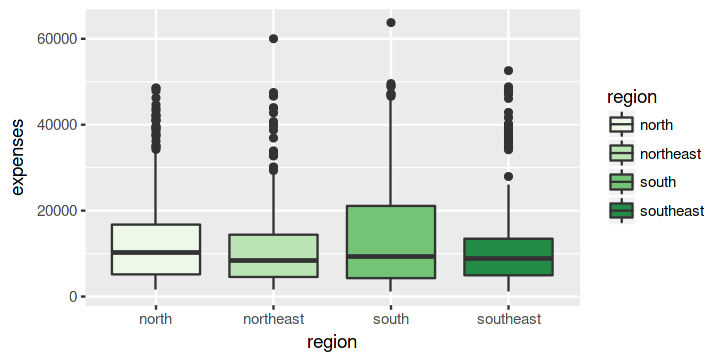

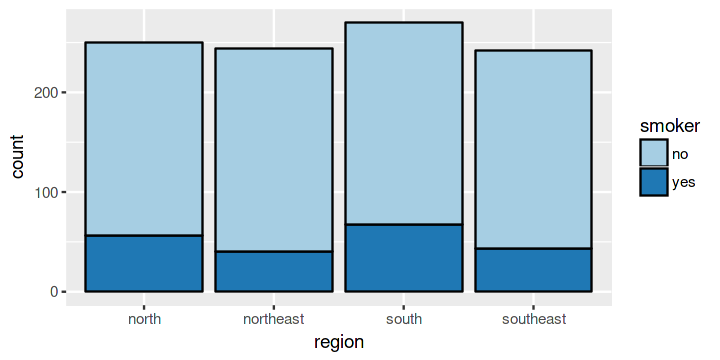

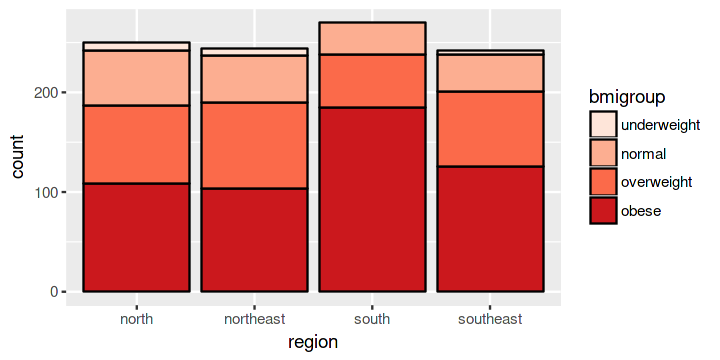

In [34]:
ggplot(df.train, aes(x = region, y = expenses, fill = region)) +
    geom_boxplot() +
    scale_fill_brewer(palette = 'Greens')

ggplot(df.train, aes(x = region, fill = smoker)) +
    geom_bar(colour = 'black') +
    scale_fill_brewer(palette = 'Paired')

ggplot(df.train, aes(x = region, fill = bmigroup)) +
    geom_bar(colour = 'black') +
    scale_fill_brewer(palette = 'Reds')

Apparently there aren't very clear trends relating medical expenses to specific regions of the country. Only people from the Southern region are associated to slightly higher expenses because they have more smokers and more obese people than other regions. The average expenses, by the way, are basically the same for all regions.

### 2.3 Feature correlations

In [35]:
# Multiple correlation test function.
#
# Computes tests for association/correlation between paired samples
# represented in the rows and columns of a matrix.
#
# Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
#
cor.mtest <- function(mat, conf.level = 0.95){
  mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

In [36]:
# Get the numerical features and also convert binary categories to numbers.
df.train.num <- df.train[, c('age', 'bmi', 'children', 'expenses')]
df.train.num$gender <- ifelse(df.train$gender == 'female', -1, 1)
df.train.num$smoker <- ifelse(df.train$smoker == 'no', -1, 1)

In order to compute the numerical correlation matrix, the binary categorical features were converted to numbers (a negative and a positive value). This way we can measure the pairwise correlations between all features except `region`.

In [37]:
# Compute the p-values for the correlation tests.
cor.p <- cor.mtest(df.train.num)[[1]]

In [38]:
# Set the default figure size.
options(repr.plot.width = 6, repr.plot.height = 4)

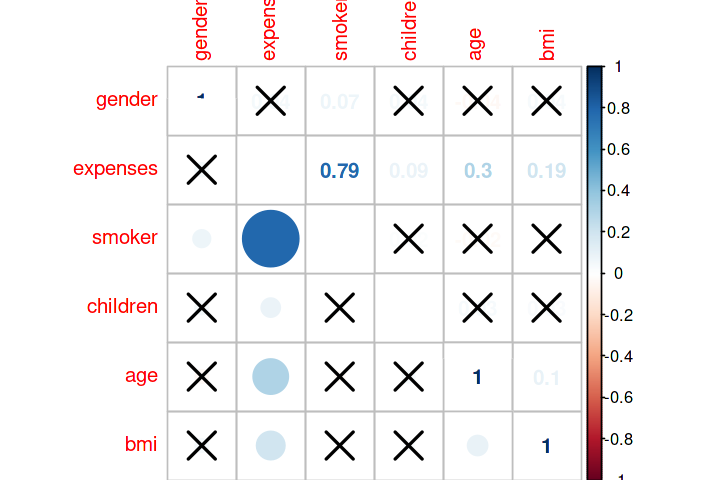

In [39]:
# Plot the pairwise feature correlation map.
corrplot.mixed(cor(df.train.num),
               lower = 'circle',
               upper = 'number',
               order = 'hclust',
               p.mat =  cor.p,
               sig.level = 0.05,
               tl.pos = 'lt')

In addition to the correlation matrix, we computed some correlation tests at 5% significance level in order to highlight (with an "x") any feature correlations that are statiscally insignificant.

In summary, the results confirm facts that we had already checked:

- `smoker` is strongly correlated to `expenses`.
- `age` and `bmi` (or `bmigroup`) are correlated to `expenses` too, but in a weaker degree.
- Other correlations are insignificant or almost insignificant.

For the `region` feature, we'll do something different: Pearson's chi-squared tests (again at 5% significance level).

In [40]:
# Pearson's chi-squared test.
chisq.test(table(df.train$region, df.train$agegroup))


	Pearson's Chi-squared test

data:  table(df.train$region, df.train$agegroup)
X-squared = 4.9535, df = 12, p-value = 0.9595


In [41]:
chisq.test(table(df.train$region, df.train$gender))


	Pearson's Chi-squared test

data:  table(df.train$region, df.train$gender)
X-squared = 0.17362, df = 3, p-value = 0.9817


In [42]:
chisq.test(table(df.train$region, df.train$bmigroup))

Warning message in chisq.test(table(df.train$region, df.train$bmigroup)):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  table(df.train$region, df.train$bmigroup)
X-squared = 51.569, df = 9, p-value = 5.453e-08


In [43]:
chisq.test(table(df.train$region, as.factor(df.train$children)))

Warning message in chisq.test(table(df.train$region, as.factor(df.train$children))):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  table(df.train$region, as.factor(df.train$children))
X-squared = 13.443, df = 15, p-value = 0.5681


In [44]:
chisq.test(table(df.train$region, df.train$smoker))


	Pearson's Chi-squared test

data:  table(df.train$region, df.train$smoker)
X-squared = 7.2764, df = 3, p-value = 0.06359


According to these statistical testes, we only have statistical evidence to believe that `bmigroup` is correlated to `region`. No evidence of correlation was found for any other feature.

PS: the warning messages found in the solutions above are due to the small cell values in the contingency tables.

## 3 Data preparation

In [45]:
# log.start function
#
# Find a constant `c` for which log(y+c) is as symmetric
# as possible at the `alpha` and 1-alpha percentiles.
# Returns a list containing the solution and a code:
#   Code=0: Constant is good.
#   Code=1: Data are already symmetric.
#   Code=2: The best solution is not large enough and has been adjusted.
#           In this case, the constant is obtained by extrapolating to the
#           left from the `beta` percentile beyond the minimum value of `y`;
#           the extrapolation is by a (small, positive) amount `gamma`.
#
# Source: http://stats.stackexchange.com/questions/41361/choosing-c-such-that-logx-c-would-remove-skew-from-the-population (whuber's answer)
#
log.start <- function(y, alpha=0.25, beta=1, gamma=0.01) {
    stats <- quantile(y, c(alpha, 1/2, 1-alpha))
    code <- 0
    
    if (diff(diff(stats)==0)) {
        const <- Inf
        code <- 1
    } else {
        const <- (stats[2]^2 - stats[1]*stats[3]) / (stats[1] + stats[3] - 2*stats[2])
        y.min <- min(y)
        
        if (const < -y.min) {
            const <- gamma * quantile(y, beta) - (1+gamma) * y.min
            code <- 2
        }
    }
    list(offset=as.numeric(const), code=code)
}

In [46]:
df2.train <- df.train
df2.test <- df.test

In [47]:
# Get the constant that unskew 95% of the distribution. 
const <- log.start(df2.train$expenses, alpha = 0.025)$offset
const

[1] 526.6459

In [48]:
# Apply the log to unskew data.
df2.train$expenses <- log(const + df2.train$expenses)
df2.test$expenses <- log(const + df2.test$expenses)

In [49]:
options(repr.plot.width = 7, repr.plot.height = 2.5)

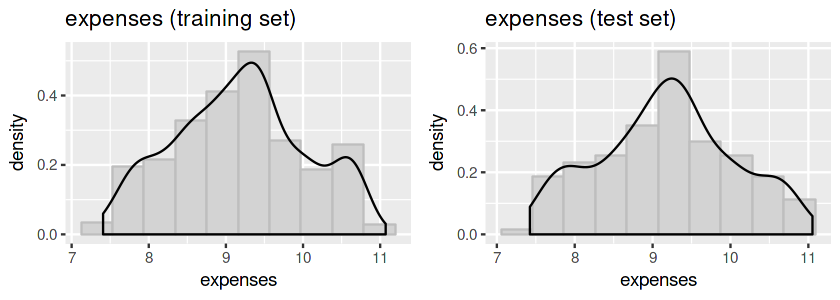

In [50]:
# Plot the distributions of expenses after the transform.
multiplot(ggplot(df2.train, aes(x = expenses, y = ..density..)) +
              geom_histogram(bins = 10, fill = 'lightgrey', colour = 'grey') +
              geom_density() +
              ggtitle('expenses (training set)'),
          ggplot(df2.test, aes(x = expenses, y = ..density..)) +
              geom_histogram(bins = 10, fill = 'lightgrey', colour = 'grey') +
              geom_density() +
              ggtitle('expenses (test set)'),
          cols = 2)

The logarithm function was applied to the `expenses`' data in order to unskew its distribution. This can help some learning algorithms to build better models (because of the assumptions they make about the data).

No more preprocessing will be done in this data set. Now we can finally build the models.

## 4 Model training

In [52]:
options(repr.plot.width = 6, repr.plot.height = 3.5)

In [51]:
# Configure the cross-validation.
train.control <- trainControl(method = 'cv', number = 10)

In total, 5 different learning algorithms will be tried to generate the predictive models. For each of them, we'll search the best combination of input parameters using grid search and 10-fold cross validation. 

### 4.1 ElasticNet

In [53]:
# Trains a regularized linear model using ElasticNet.
enet.grid <- expand.grid(fraction = seq(0.5, 1, 0.1), lambda = seq(0, 1, 0.1))
enet <- train(expenses ~ .,
              data = df2.train,
              method = 'enet',
              metric = 'RMSE',
              trControl = train.control,
              tuneGrid = enet.grid)

Loading required package: elasticnet
Loading required package: lars
Loaded lars 1.2



In [54]:
enet

Elasticnet 

1006 samples
   8 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 906, 906, 905, 906, 905, 906, ... 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared 
  0.0     0.5       0.4371378  0.7513462
  0.0     0.6       0.4186557  0.7599287
  0.0     0.7       0.4146008  0.7623895
  0.0     0.8       0.4139995  0.7631170
  0.0     0.9       0.4138009  0.7635172
  0.0     1.0       0.4137610  0.7637156
  0.1     0.5       0.4702627  0.7372468
  0.1     0.6       0.4371776  0.7514237
  0.1     0.7       0.4196929  0.7599248
  0.1     0.8       0.4160782  0.7605856
  0.1     0.9       0.4156979  0.7606656
  0.1     1.0       0.4160309  0.7604532
  0.2     0.5       0.4673122  0.7382732
  0.2     0.6       0.4358379  0.7528090
  0.2     0.7       0.4204096  0.7594120
  0.2     0.8       0.4175756  0.7587708
  0.2     0.9       0.4170445  0.7588919
  0.2     1.0       0.4173049  0.7590306
  0.3     0.5  

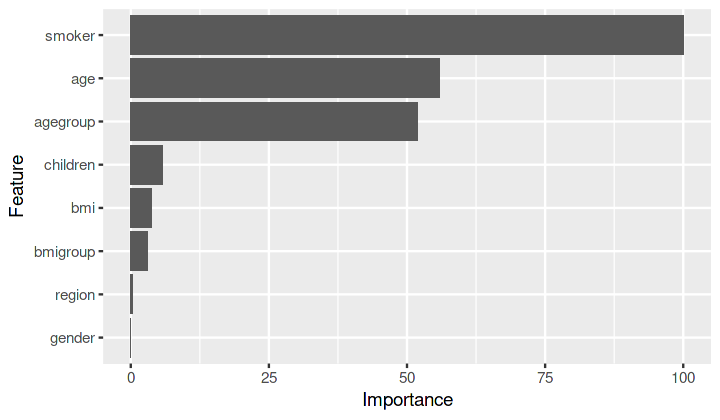

In [55]:
# Plot the feature importances.
ggplot(varImp(enet))

Our first model is a regularized linear model generated by the ElasticNet algorithm. It achieved an average RMSE (root mean squared error) of about 0.4 in the validation sets, and an R^2 (coefficient of determination) above 0.76. `smoker` and `age` are by far the most important features for this model.

### 4.2 Classification And Regression Trees (CART)

In [56]:
# Trains a nonlinear model using CART.
cart.grid <- expand.grid(cp = seq(0, 0.03, 0.001))
cart <- train(expenses ~ .,
              data = df2.train,
              method = 'rpart',
              metric = 'RMSE',
              trControl = train.control,
              tuneGrid = cart.grid)

Loading required package: rpart


In [57]:
cart

CART 

1006 samples
   8 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 905, 905, 905, 904, 906, 906, ... 
Resampling results across tuning parameters:

  cp     RMSE       Rsquared 
  0.000  0.3762477  0.8004353
  0.001  0.3697784  0.8062801
  0.002  0.3705222  0.8053840
  0.003  0.3695620  0.8056864
  0.004  0.3725538  0.8028063
  0.005  0.3757023  0.7992318
  0.006  0.3782108  0.7970062
  0.007  0.3810500  0.7941794
  0.008  0.3802859  0.7949207
  0.009  0.3874384  0.7872081
  0.010  0.3864988  0.7883147
  0.011  0.3891940  0.7876584
  0.012  0.3916756  0.7853104
  0.013  0.3916756  0.7853104
  0.014  0.3949268  0.7819480
  0.015  0.3949268  0.7819480
  0.016  0.3962643  0.7809498
  0.017  0.3961974  0.7808435
  0.018  0.3989452  0.7776779
  0.019  0.3976082  0.7788655
  0.020  0.3976082  0.7788655
  0.021  0.4013697  0.7750205
  0.022  0.4038137  0.7723314
  0.023  0.4057385  0.7703393
  0.024  0.4095471  0.7667578
  0.025  0.4095471  

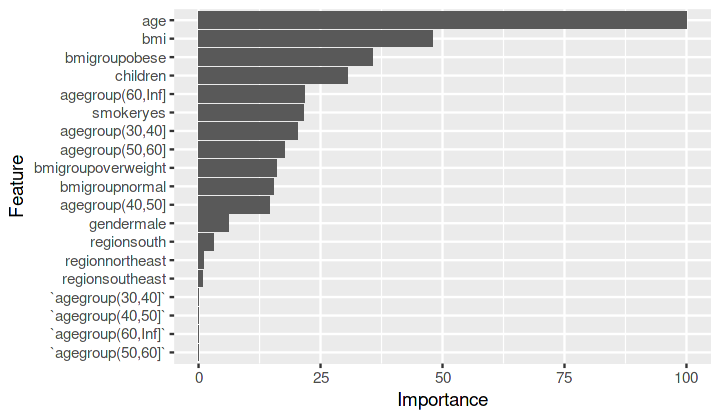

In [58]:
# Plot the feature importances.
ggplot(varImp(cart))

The second model is a decision tree model generated by the CART algorithm. It achieved an average RMSE (root mean squared error) of about 0.37 in the validation sets, and an R^2 (coefficient of determination) above 0.80. `age`, `bmi` and `children` were some of the most important features for this model. The optimal value for the complexity parameter `cp` (which specifies how the cost of a tree is penalized by the number of terminal nodes) was `cp = 0.003` - a small value, hence the final tree must be relatively large.

### 4.3 k-Nearest Neighbors (kNN)

In [59]:
# Trains a nonlinear model using kNN.
knn.grid <- expand.grid(k = 1:21)
knn <- train(expenses ~ .,
             data = df2.train,
             method = 'knn',
             metric = 'RMSE',
             trControl = train.control,
             tuneGrid = knn.grid,
             preProc = c('center', 'scale'))

In [60]:
knn

k-Nearest Neighbors 

1006 samples
   8 predictors

Pre-processing: centered (15), scaled (15) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 904, 906, 905, 906, 906, 906, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared 
   1  0.5029026  0.6825306
   2  0.4616767  0.7149236
   3  0.4507700  0.7236845
   4  0.4409594  0.7344421
   5  0.4478413  0.7280864
   6  0.4473020  0.7305412
   7  0.4499968  0.7282574
   8  0.4585780  0.7201107
   9  0.4634047  0.7165334
  10  0.4673069  0.7150294
  11  0.4701442  0.7144731
  12  0.4722323  0.7152606
  13  0.4769694  0.7120980
  14  0.4788204  0.7110750
  15  0.4803838  0.7112197
  16  0.4827262  0.7103103
  17  0.4860485  0.7078276
  18  0.4896737  0.7040482
  19  0.4927291  0.7004067
  20  0.4944303  0.7001331
  21  0.4957020  0.6998529

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was k = 4. 

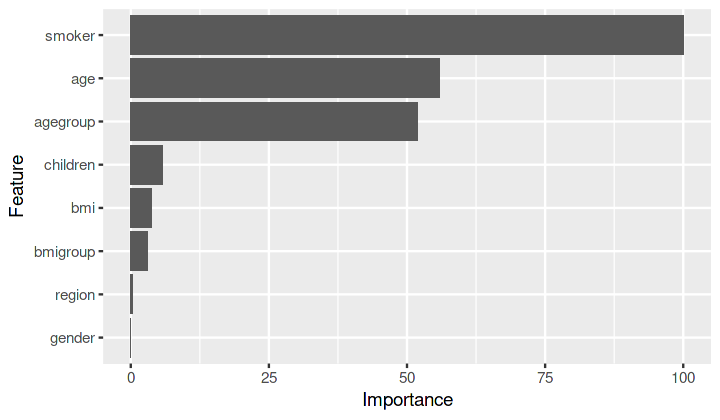

In [61]:
# Plot the feature importances.
ggplot(varImp(knn))

The third model is a non-linear model generated by the kNN algorithm. It achieved an average RMSE (root mean squared error) of about 0.44 in the validation sets, and an R^2 (coefficient of determination) above 0.73. `age`, `bmi` and `children` were some of the most important features for this model. The optimal value for the `k` parameter (which specifies the number of nearest neighbors whose outputs are averaged) was `k = 4` - therefore the decision boundary must be not too aliased nor too smooth.

### 4.4 Random Forest

In [62]:
# Trains a nonlinear model using Random Forest.
rf.grid <- expand.grid(mtry = 1:(ncol(df2.train) - 1))
rf <- train(expenses ~ .,
            data = df2.train,
            method = 'rf',
            metric = 'RMSE',
            trControl = train.control,
            tuneGrid = rf.grid,
            importance = TRUE)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [63]:
rf

Random Forest 

1006 samples
   8 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 906, 906, 906, 904, 906, 905, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared 
  1     0.6469653  0.7418656
  2     0.4526776  0.8004699
  3     0.3810335  0.8149805
  4     0.3658454  0.8161203
  5     0.3631727  0.8150230
  6     0.3646689  0.8129884
  7     0.3653647  0.8120063
  8     0.3670200  0.8101550

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was mtry = 5. 

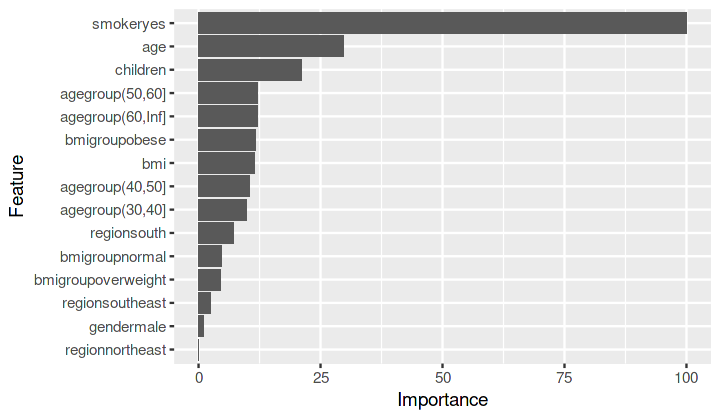

In [64]:
# Plot the feature importances.
ggplot(varImp(rf))

The fourth model is an ensemble tree-based model generated by the Random Forest algorithm. It achieved an average RMSE (root mean squared error) of about 0.36 in the validation sets, and an R^2 (coefficient of determination) above 0.81. `smoker` was by far the most important feature for this model, followed by `age` and `children`. The optimal value for the `mtry` parameter (which defines the number of random features considered by each decision tree) was `mtry = 5`.

### 4.4 eXtreme Gradient Boosting (XGBoost)

In [65]:
# Trains a nonlinear model using XGBoost.
xgb.grid <- expand.grid(nrounds = c(500),
                        max_depth = c(2, 3, 4),
                        eta = c(0.1),
                        gamma = c(0.2),
                        subsample = c(0.5, 0.75, 1),
                        colsample_bytree = c(0.5, 0.75, 1),
                        min_child_weight = c(0.5))
xgb <- train(expenses ~ .,
             data = df2.train,
             method = 'xgbTree',
             metric = 'RMSE',
             trControl = train.control,
             tuneGrid = xgb.grid)

Loading required package: xgboost
Loading required package: plyr


In [66]:
xgb

eXtreme Gradient Boosting 

1006 samples
   8 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 906, 906, 905, 906, 905, 905, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  subsample  RMSE       Rsquared 
  2          0.50              0.50       0.3720438  0.8083449
  2          0.50              0.75       0.3689550  0.8108173
  2          0.50              1.00       0.3594606  0.8194886
  2          0.75              0.50       0.3742696  0.8061167
  2          0.75              0.75       0.3711061  0.8087693
  2          0.75              1.00       0.3552139  0.8239236
  2          1.00              0.50       0.3787305  0.8013050
  2          1.00              0.75       0.3735858  0.8067794
  2          1.00              1.00       0.3561669  0.8230111
  3          0.50              0.50       0.3806689  0.8002473
  3          0.50              0.75       0.3800921  0.7996150
  3          0.50      

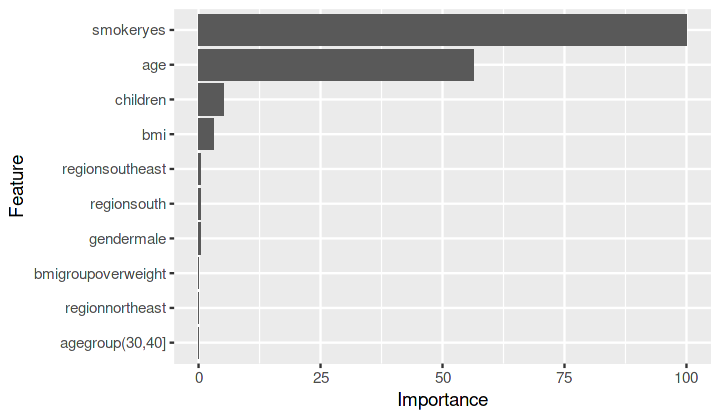

In [67]:
# Plot the feature importances.
ggplot(varImp(xgb))

Our last model is an ensemble gradient boosting model generated by the XGBoost algorithm. It achieved an average RMSE (root mean squared error) of about 0.35 in the validation sets, and an R^2 (coefficient of determination) above 0.82. `smoker` was by far the most important feature for this model, followed by `age` and `children`. This algorithm requires several parameters and some of them were previously tuned, but basically the optimal combination involved using a high number of weak models (`nrounds = 500`, `max_depth = 3`) and resampling data from the whole set of observations and features (`subsample = 1`, `colsample_bytree = 3`).

## 5 Model evaluation

Now all the five models are going to be evaluated in the test set. The same performance metrics (RMSE and R^2) are used again.

In [68]:
# Make preditions using the ElasticNet model.
enet.pred <- predict(enet, df2.test)

In [69]:
# Compute the test results in terms of RMSE and R^2.
enet.results <- postResample(pred = enet.pred, obs = df2.test$expenses)
enet.results

RMSE  Rsquared 
0.3907159 0.7954615

In [70]:
# Make preditions using the CART model.
cart.pred <- predict(cart, df2.test)

In [71]:
# Compute the test results in terms of RMSE and R^2.
cart.results <- postResample(pred = cart.pred, obs = df2.test$expenses)
cart.results

RMSE  Rsquared 
0.3299625 0.8537440

In [72]:
# Make preditions using the kNN model.
knn.pred <- predict(knn, df2.test)

In [73]:
# Compute the test results in terms of RMSE and R^2.
knn.results <- postResample(pred = knn.pred, obs = df2.test$expenses)
knn.results

RMSE  Rsquared 
0.4027504 0.7840894

In [74]:
# Make preditions using the Random Forest model.
rf.pred <- predict(rf, df2.test)

In [75]:
# Compute the test results in terms of RMSE and R^2.
rf.results <- postResample(pred = rf.pred, obs = df2.test$expenses)
rf.results

RMSE  Rsquared 
0.3395118 0.8471420

In [76]:
# Make preditions using the XGBoost model.
xgb.pred <- predict(xgb, df2.test)

In [77]:
# Compute the test results in terms of RMSE and R^2.
xgb.results <- postResample(pred = xgb.pred, obs = df2.test$expenses)
xgb.results

RMSE  Rsquared 
0.3169741 0.8656171

In summary, all models did fine in predicting the expenses of people in the test set. The lowest RMSE value was about 0.31 (achieved by the XGBoost model) and the highest value was around 0.4 (kNN model). The highest R^2 coefficient was about 0.87 (XGBoost model again) and the lowest coefficient was 0.78 (kNN model). These are good results, showing that the models did not overfit and were capable of generalizing predictions for new data.

**IMPORTANT:** notice that the models are actually predicting the *logarithm* of the expenses. If we wanted to get the correct values, we'd need to apply the exponential function to the models' predictions, i.e. `y = exp(z)-const`, where `z` is the model output and `const` is the same constant estimated in the data preparation stage.

In [78]:
# Put all results together in a single data frame.
all.results <- data.frame(
    algorithm = c('ElasticNet', 'CART', 'kNN', 'Random Forest', 'XGBoost'),
    RMSE = c(enet.results[1], cart.results[1], knn.results[1], rf.results[1], xgb.results[1]),
    Rsquared = c(enet.results[2], cart.results[2], knn.results[2], rf.results[2], xgb.results[2])
)

In [79]:
all.results

algorithm,RMSE,Rsquared
ElasticNet,0.3907159,0.7954615
CART,0.3299625,0.8537440
kNN,0.4027504,0.7840894
Random Forest,0.3395118,0.8471420
XGBoost,0.3169741,0.8656171


In [80]:
options(repr.plot.width = 8, repr.plot.height = 3.5)

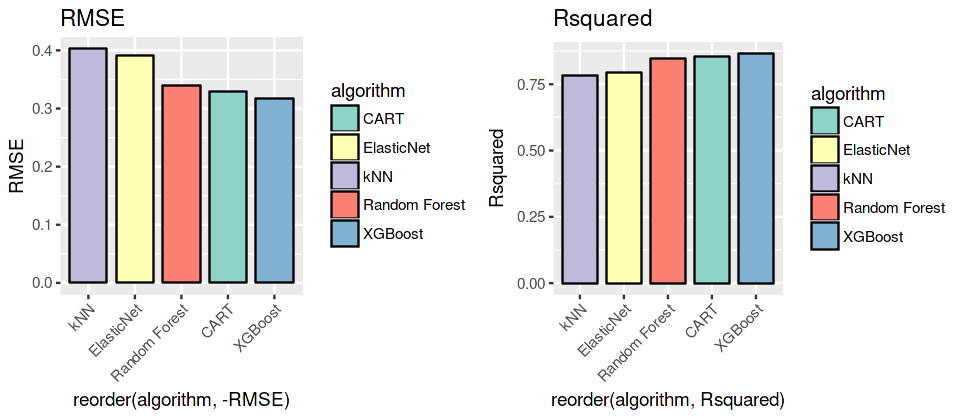

In [81]:
# Plot the final results.
multiplot(ggplot(all.results, aes(x = reorder(algorithm, -RMSE), y = RMSE, fill = algorithm)) +
              geom_bar(stat = 'identity', colour = 'black', width = 0.8) +
              scale_fill_brewer(palette = 'Set3') +
              theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
              ggtitle('RMSE'),
          ggplot(all.results, aes(x = reorder(algorithm, Rsquared), y = Rsquared, fill = algorithm)) +
              geom_bar(stat = 'identity', colour = 'black', width = 0.8) +
              scale_fill_brewer(palette = 'Set3') +
              theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
              ggtitle('Rsquared'),
          cols = 2)

As shown by the bar charts above, the XGBoost algorithm generated the best predictive model for this data set.